<a href="https://colab.research.google.com/github/DavisRayM/msft-stock-prediction/blob/main/msft-prediction.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Assignment 4

Author: Davis Muro

For CPSC 5610

Microsoft Stock Prediction

In [1]:
import tensorflow as tf
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from sklearn.preprocessing import MinMaxScaler
from tensorflow.keras import activations
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Dense, SimpleRNN, LSTM, GRU, Input, BatchNormalization, Layer
from tensorflow.keras.callbacks import EarlyStopping
from typing import Tuple, List

In [2]:
np.random.seed(25)
tf.random.set_seed(25)

## Preprocessing

In [3]:
df = pd.read_csv('data/MSFT.csv', parse_dates=['Date'], index_col='Date')

# Sort dataframe by `Date` (Ascending)
df.sort_index(inplace=True)

# Drop Adj Close
df.drop(columns=['Adj Close'], inplace=True)

df.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,59.779999,60.520000,59.779999,60.419998,31664800
2016-11-08,60.549999,60.779999,60.150002,60.470001,22935400
2016-11-09,60.000000,60.590000,59.200001,60.169998,49632500
2016-11-10,60.480000,60.490002,57.630001,58.700001,57822400
2016-11-11,58.230000,59.119999,58.009998,59.020000,38767800


In [4]:
df['Open'].max(), df['High'].max(), df['Low'].max(), df['Close'].max(), df['Volume'].max()

(338.51001, 338.790009, 334.420013, 336.440002, 111242100)

In [5]:
df.shape

(1259, 5)

In [85]:
scaler = MinMaxScaler()
volume_scaler = MinMaxScaler()
features = ['Open', 'High', 'Low', 'Close', 'Volume']

def scale_features(df):
  df = df.copy(deep=True)

  df[features[:4]] = scaler.fit_transform(df[features[:4]])
  df[features[4:]] = volume_scaler.fit_transform(df[features[4:]])

  return df

normalized = scale_features(df)
normalized.head(5)

,Open,High,Low,Close,Volume
Date,,,,,
2016-11-07,0.005530,0.005148,0.009021,0.008264,0.233481
2016-11-08,0.008277,0.006078,0.010356,0.008444,0.149396
2016-11-09,0.006315,0.005398,0.006928,0.007366,0.406553
2016-11-10,0.008028,0.005041,0.001263,0.002084,0.485441
2016-11-11,0.000000,0.000143,0.002634,0.003234,0.301900


In [7]:
normalized['Open'].max(), normalized['High'].max(), normalized['Low'].max(), normalized['Close'].max(), normalized['Volume'].max()

(1.0, 1.0, 0.9999999999999999, 1.0, 1.0)

In [8]:
normalized.shape

(1259, 5)

## Windowing

In [9]:
train_size = normalized.shape[0] * 90 // 100
test_size = normalized.shape[0] - train_size
train_size, test_size

(1133, 126)

In [10]:
def window(df, n_steps, batch_size):
    ds = tf.data.Dataset.from_tensor_slices(df)
    ds = ds.window(n_steps + 1, shift=1, drop_remainder=True)
    ds = ds.flat_map(lambda window: window.batch(n_steps + 1))
    ds = ds.map(lambda window: (window[:-1], window[-1]))
    ds = ds.batch(batch_size).prefetch(1)
    return ds

In [11]:
timesteps = 20
batch_size = 32

train = window(normalized[:train_size], timesteps, batch_size)
for (X, y) in train.take(1):
  print(f"X Shape: {X.shape}, Y Shape: {y.shape}")
train

X Shape: (32, 20, 5), Y Shape: (32, 5)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

In [12]:
test = window(normalized[train_size:], timesteps, batch_size)

for X_batch, y_batch in test.take(1):
  print(f"X Shape: {X.shape}, Y Shape: {y.shape}")
test

X Shape: (32, 20, 5), Y Shape: (32, 5)


<_PrefetchDataset element_spec=(TensorSpec(shape=(None, None, 5), dtype=tf.float64, name=None), TensorSpec(shape=(None, 5), dtype=tf.float64, name=None))>

## Modelling

In [13]:
class BatchNormSimpleRNN(Layer):
    def __init__(self, units, return_sequences=False, dropout=0.2, recurrent_dropout=0.2, activation='tanh', **kwargs):
        super().__init__(**kwargs)
        self.simple_rnn = SimpleRNN(
            units,
            activation=None,
            return_sequences=return_sequences,
            dropout=dropout,
            recurrent_dropout=recurrent_dropout,
            **kwargs
        )
        self.batch_norm = BatchNormalization()
        self.activation_fn = activations.get(activation)

    def call(self, inputs, training=None):
        x = self.simple_rnn(inputs, training=training)
        x = self.batch_norm(x, training=training)
        return self.activation_fn(x)

In [32]:
def create_model(kind: str = "simple", input_shape: Tuple[int, int] = (timesteps, 5), neurons: int = 64):
  model = tf.keras.models.Sequential()
  model.add(Input(shape=input_shape))

  if kind == "simple":
    model.add(BatchNormSimpleRNN(neurons, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "lstm":
    model.add(LSTM(neurons, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  elif kind == "gru":
    model.add(GRU(neurons, return_sequences=False, dropout=0.2, recurrent_dropout=0.2))
  else:
    assert False, "Unsupported kind: " + kind

  model.add(Dense(input_shape[1]))
  model.compile(loss="mse", optimizer="adam", metrics=["mae"])
  return model

In [36]:
early_stopping = EarlyStopping(
    monitor='val_mae',
    patience=3,
    restore_best_weights=True
)

epochs = 30

### Simple RNN

Uses SimpleRNN + Batch normalization layers with 1 hidden layer.

In [37]:
simple = create_model(kind="simple")
simple.summary()

Model: "sequential_5"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ batch_norm_simple_rnn_4         │ (None, 64)             │         4,736 │
│ (BatchNormSimpleRNN)            │                        │               │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_5 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 5,061 (19.77 KB)

 Trainable params: 4,933 (19.27 KB)

 Non-trainable params: 128 (512.00 B)

In [38]:
simple.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping])

Epoch 1/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 29ms/step - loss: 0.3911 - mae: 0.4589 - val_loss: 0.8057 - val_mae: 0.8075
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 17ms/step - loss: 0.0952 - mae: 0.2345 - val_loss: 0.4931 - val_mae: 0.6384
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0754 - mae: 0.2185 - val_loss: 0.3127 - val_mae: 0.5115
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 15ms/step - loss: 0.0510 - mae: 0.1782 - val_loss: 0.2703 - val_mae: 0.4759
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0422 - mae: 0.1624 - val_loss: 0.3017 - val_mae: 0.5062
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0422 - mae: 0.1636 - val_loss: 0.2355 - val_mae: 0.4474
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 33ms/step - loss: 0.0467 - mae: 0.1738 - val_loss: 0.2467 - val_mae: 0.4577
Epoch 8/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 23ms/step - loss: 0.0477 - mae: 0.1799 - val_loss: 0.2436 - val_mae: 0.4574
Epoch 9/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 16ms/step - loss: 0.039

In [39]:
result = pd.DataFrame(simple.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.300116,0.415988,0.805743,0.807535
1,0.108201,0.254283,0.493095,0.638399
2,0.080645,0.223380,0.312687,0.511529
3,0.060655,0.190638,0.270308,0.475909
4,0.050127,0.175777,0.301735,0.506191


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

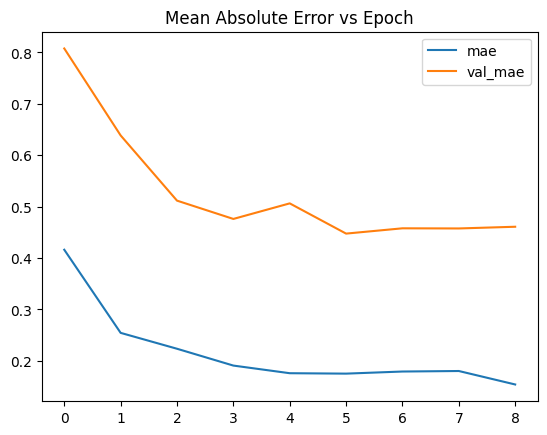

In [40]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

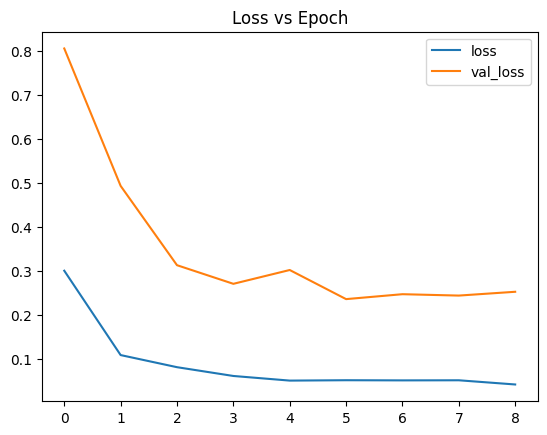

In [41]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### GRU Model

Uses a GRU layer with one hidden layer.

In [42]:
gru = create_model(kind="gru")
gru.summary()

Model: "sequential_6"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ gru_1 (GRU)                     │ (None, 64)             │        13,632 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_6 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 13,957 (54.52 KB)

 Trainable params: 13,957 (54.52 KB)

 Non-trainable params: 0 (0.00 B)

In [43]:
gru.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping])

Epoch 1/30
     34/Unknown 44s 48ms/step - loss: 0.0055 - mae: 0.0530

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 45s 85ms/step - loss: 0.0057 - mae: 0.0537 - val_loss: 0.0124 - val_mae: 0.1034
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 70ms/step - loss: 0.0180 - mae: 0.1099 - val_loss: 0.0030 - val_mae: 0.0401
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 30ms/step - loss: 0.0102 - mae: 0.0845 - val_loss: 0.0053 - val_mae: 0.0526
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 31ms/step - loss: 0.0080 - mae: 0.0751 - val_loss: 0.0059 - val_mae: 0.0644
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0040 - mae: 0.0436 - val_loss: 0.0079 - val_mae: 0.0829


In [47]:
result = pd.DataFrame(gru.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.008374,0.065604,0.012405,0.103390
1,0.015617,0.097935,0.002986,0.040069
2,0.011550,0.082642,0.005288,0.052605
3,0.010398,0.079714,0.005866,0.064354
4,0.007489,0.061159,0.007852,0.082908


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

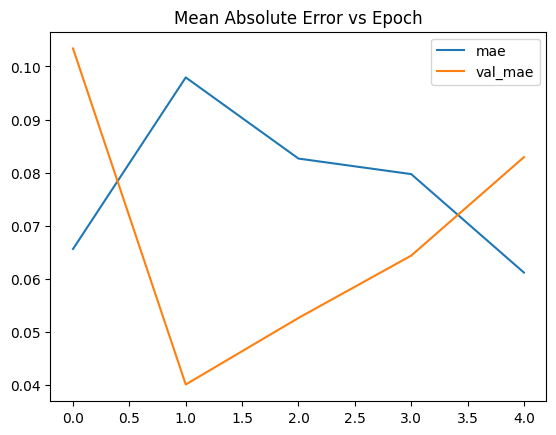

In [48]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

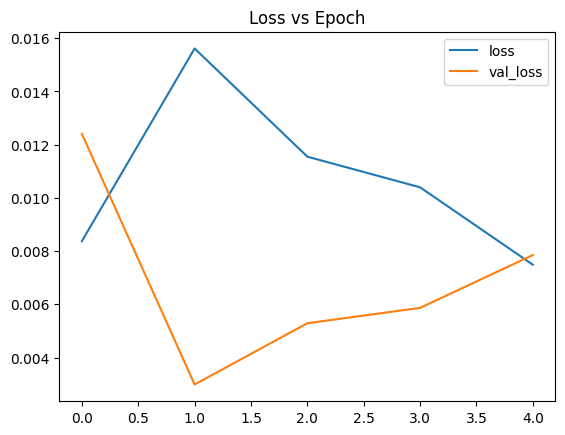

In [49]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

### LSTM

Uses LSTM layers with 1 hidden layer.

In [51]:
lstm = create_model(kind="lstm")
lstm.summary()

Model: "sequential_7"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━┓
┃ Layer (type)                    ┃ Output Shape           ┃       Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━┩
│ lstm (LSTM)                     │ (None, 64)             │        17,920 │
├─────────────────────────────────┼────────────────────────┼───────────────┤
│ dense_7 (Dense)                 │ (None, 5)              │           325 │
└─────────────────────────────────┴────────────────────────┴───────────────┘

 Total params: 18,245 (71.27 KB)

 Trainable params: 18,245 (71.27 KB)

 Non-trainable params: 0 (0.00 B)

In [52]:
lstm.fit(train, epochs=epochs, validation_data=test, callbacks=[early_stopping])

Epoch 1/30
     34/Unknown 7s 31ms/step - loss: 0.0058 - mae: 0.0538

/usr/local/lib/python3.11/dist-packages/keras/src/trainers/epoch_iterator.py:151: UserWarning: Your input ran out of data; interrupting training. Make sure that your dataset or generator can generate at least `steps_per_epoch * epochs` batches. You may need to use the `.repeat()` function when building your dataset.
  self._interrupted_warning()


35/35 ━━━━━━━━━━━━━━━━━━━━ 8s 60ms/step - loss: 0.0060 - mae: 0.0544 - val_loss: 0.0099 - val_mae: 0.0894
Epoch 2/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 33ms/step - loss: 0.0183 - mae: 0.1117 - val_loss: 0.0056 - val_mae: 0.0628
Epoch 3/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 36ms/step - loss: 0.0095 - mae: 0.0806 - val_loss: 0.0057 - val_mae: 0.0602
Epoch 4/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 1s 35ms/step - loss: 0.0066 - mae: 0.0679 - val_loss: 0.0034 - val_mae: 0.0467
Epoch 5/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 2s 32ms/step - loss: 0.0050 - mae: 0.0530 - val_loss: 0.0058 - val_mae: 0.0676
Epoch 6/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 3s 74ms/step - loss: 0.0043 - mae: 0.0448 - val_loss: 0.0043 - val_mae: 0.0576
Epoch 7/30
35/35 ━━━━━━━━━━━━━━━━━━━━ 4s 35ms/step - loss: 0.0044 - mae: 0.0462 - val_loss: 0.0053 - val_mae: 0.0653


In [53]:
result = pd.DataFrame(lstm.history.history)
result.head()

,loss,mae,val_loss,val_mae
0,0.008469,0.065988,0.009890,0.089360
1,0.014783,0.095048,0.005574,0.062764
2,0.010575,0.078681,0.005734,0.060230
3,0.009148,0.072451,0.003352,0.046681
4,0.007621,0.064634,0.005819,0.067553


<Axes: title={'center': 'Mean Absolute Error vs Epoch'}>

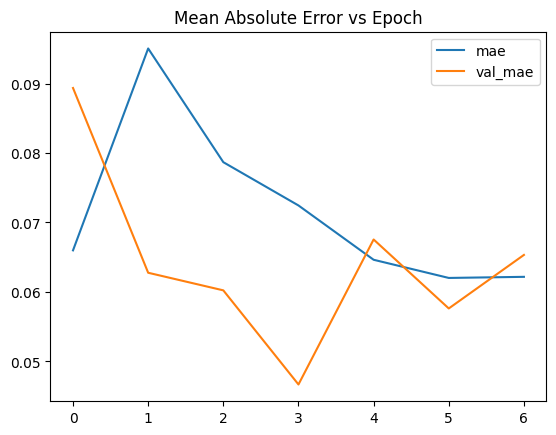

In [54]:
result[['mae', 'val_mae']].plot(title="Mean Absolute Error vs Epoch")

<Axes: title={'center': 'Loss vs Epoch'}>

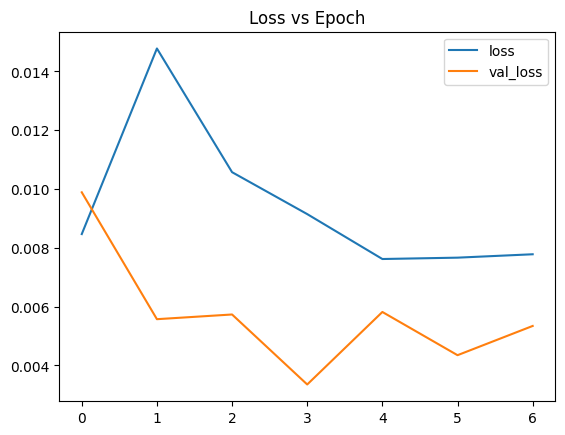

In [55]:
result[['loss','val_loss']].plot(title="Loss vs Epoch")

## Evaluation

In [66]:
df.index.max(), df.loc[df.index.max()].shape

(Timestamp('2021-11-05 00:00:00'), (5,))

In [80]:
# Predict all 5 columns for the 10 business days between 11/08/2021 and 11/19/2021
range = pd.bdate_range(start="2021-11-05", end="2021-11-19")
range

DatetimeIndex(['2021-11-05', '2021-11-08', '2021-11-09', '2021-11-10',
               '2021-11-11', '2021-11-12', '2021-11-15', '2021-11-16',
               '2021-11-17', '2021-11-18', '2021-11-19'],
              dtype='datetime64[ns]', freq='B')

In [94]:
def predict_range(model, last_window, dates):
  predictions = []
  last_window = np.expand_dims(last_window, axis=0)

  for _ in dates:
    pred = model.predict(last_window)
    predictions.append(pred[0])
    pred = np.expand_dims(pred, axis=1)  # Shape: (1, 1, features)
    last_window = np.concatenate([last_window[:, 1:, :], pred], axis=1)  # Still (1, 20, 5)

  return np.array(predictions)

pred_existing = 1
predictions = predict_range(simple, normalized[-(timesteps + pred_existing): -pred_existing].values, range)
predictions

1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 58ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 55ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 60ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 56ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 54ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 57ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 50ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 52ms/step
1/1 ━━━━━━━━━━━━━━━━━━━━ 0s 86ms/step


array([[0.297556  , 0.2987586 , 0.28963795, 0.2940365 , 0.23394307],
       [0.2974046 , 0.29907775, 0.28922358, 0.294129  , 0.23403972],
       [0.29581574, 0.2973153 , 0.28793126, 0.2924861 , 0.2337476 ],
       [0.29500216, 0.2960282 , 0.2865107 , 0.2912686 , 0.23313999],
       [0.2943166 , 0.2947641 , 0.28516293, 0.2901228 , 0.23276064],
       [0.2944673 , 0.29479292, 0.28526434, 0.29021734, 0.23293772],
       [0.2949565 , 0.29514366, 0.28567186, 0.29081133, 0.2331366 ],
       [0.2941548 , 0.29462978, 0.28526667, 0.2905197 , 0.23312128],
       [0.2938063 , 0.29429883, 0.2847835 , 0.2903121 , 0.2328679 ],
       [0.2933016 , 0.29349393, 0.28411236, 0.28969586, 0.23267236],
       [0.29116088, 0.29035255, 0.28107297, 0.28709668, 0.23175699]],
      dtype=float32)

In [95]:
def plot_predictions(dates, pred, feature_names):
  for i, feature in enumerate(feature_names):
    plt.figure(figsize=(10, 5))
    plt.plot(dates, pred[:, i], label=f'Predicted {feature}')
    plt.xlabel('Date')
    plt.ylabel(feature)
    plt.title(f'Stock {feature} Prediction')
    plt.legend()
    plt.show()

print(features)

['Open', 'High', 'Low', 'Close', 'Volume']


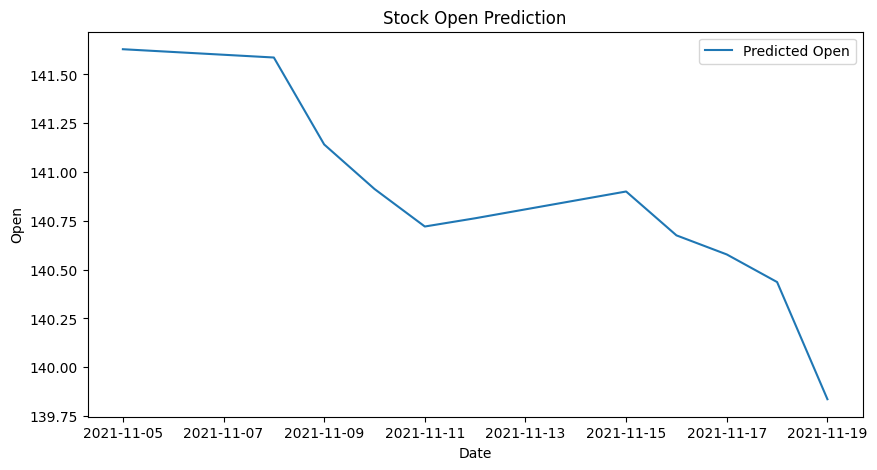

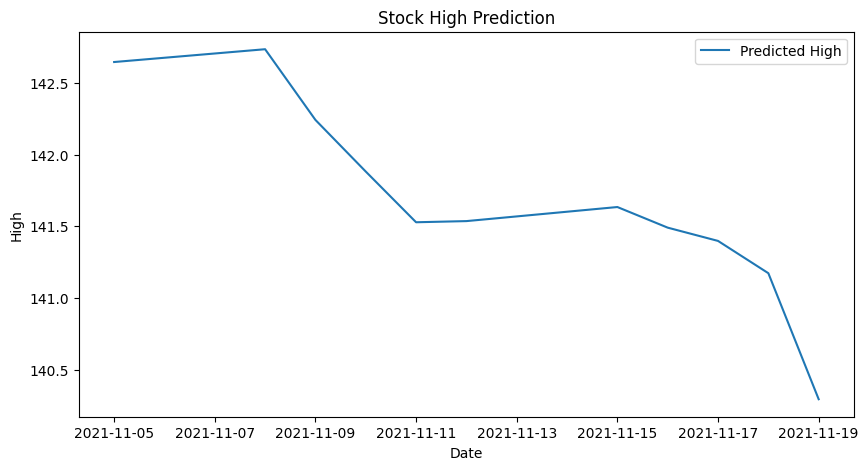

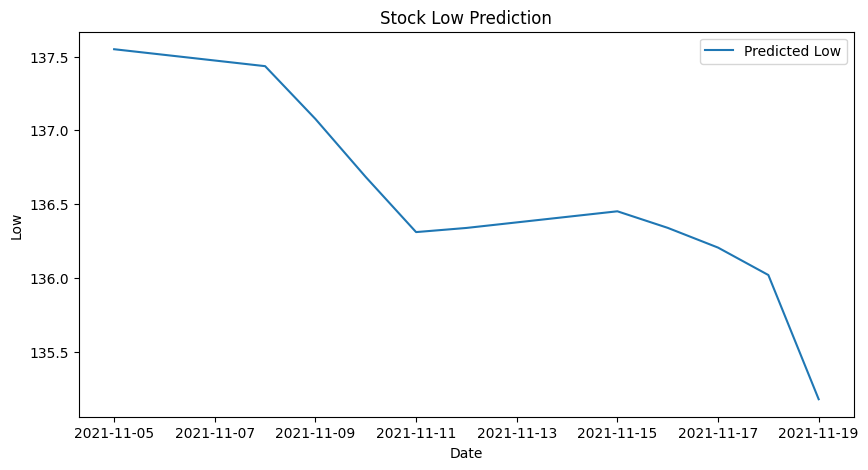

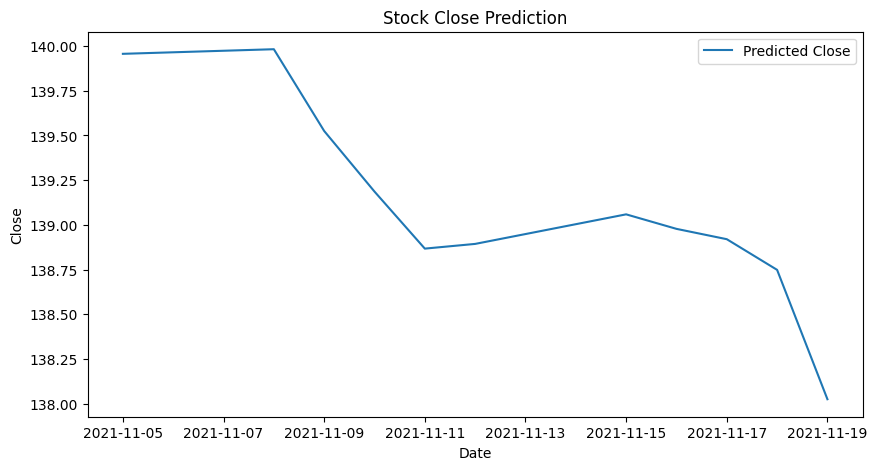

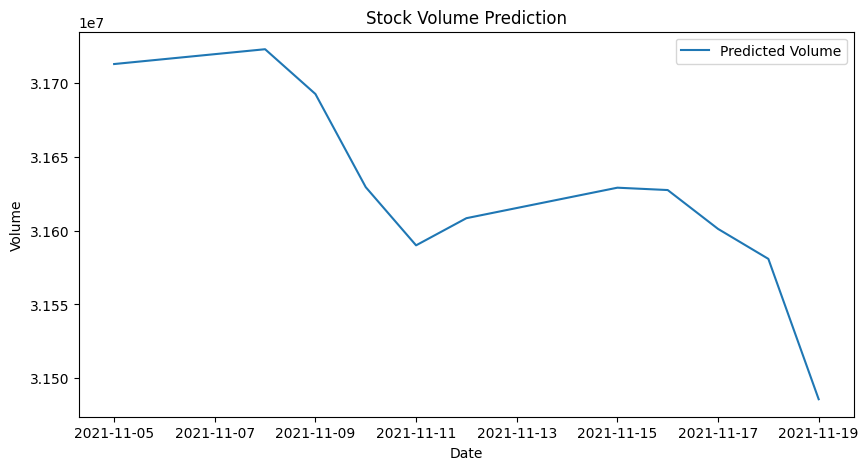

In [96]:
def inverse_scale(predictions):
    prices_scaled = predictions[:, :4]
    volume_scaled = predictions[:, 4:]

    prices_unscaled = scaler.inverse_transform(prices_scaled)
    volume_unscaled = volume_scaler.inverse_transform(volume_scaled)

    # concatenate back into a single array (num_steps, 5)
    unscaled = np.concatenate([prices_unscaled, volume_unscaled], axis=1)
    return unscaled
plot_predictions(range, inverse_scale(predictions), features)

In [99]:
df.loc[df.idxmax()]

,Open,High,Low,Close,Volume
Date,,,,,
2021-11-05,338.510010,338.790009,334.420013,336.059998,22564000
2021-11-05,338.510010,338.790009,334.420013,336.059998,22564000
2021-11-05,338.510010,338.790009,334.420013,336.059998,22564000
2021-11-04,332.890015,336.540009,329.510010,336.440002,23992200
2018-12-21,101.629997,103.000000,97.459999,98.230003,111242100


In [103]:
inverse_scale(predictions[0:, :])

array([[1.4162901e+02, 1.4264577e+02, 1.3755026e+02, 1.3995625e+02,
        3.1712750e+07],
       [1.4158656e+02, 1.4273505e+02, 1.3743542e+02, 1.3998199e+02,
        3.1722784e+07],
       [1.4114125e+02, 1.4224207e+02, 1.3707727e+02, 1.3952473e+02,
        3.1692458e+07],
       [1.4091321e+02, 1.4188205e+02, 1.3668358e+02, 1.3918588e+02,
        3.1629378e+07],
       [1.4072105e+02, 1.4152847e+02, 1.3631006e+02, 1.3886697e+02,
        3.1589994e+07],
       [1.4076331e+02, 1.4153653e+02, 1.3633817e+02, 1.3889330e+02,
        3.1608378e+07],
       [1.4090041e+02, 1.4163464e+02, 1.3645111e+02, 1.3905861e+02,
        3.1629024e+07],
       [1.4067572e+02, 1.4149089e+02, 1.3633881e+02, 1.3897745e+02,
        3.1627434e+07],
       [1.4057803e+02, 1.4139833e+02, 1.3620491e+02, 1.3891966e+02,
        3.1601130e+07],
       [1.4043658e+02, 1.4117319e+02, 1.3601891e+02, 1.3874815e+02,
        3.1580830e+07],
       [1.3983658e+02, 1.4029451e+02, 1.3517657e+02, 1.3802475e+02,
        3.14

In [ ]:
!jupyter nbconvert msft_prediction.ipynb --to html

[NbConvertApp] Converting notebook msft_prediction.ipynb to html
[NbConvertApp] WARNING | Alternative text is missing on 9 image(s).
[NbConvertApp] Writing 915707 bytes to msft_prediction.html
